In [1]:
%matplotlib inline
import cv2 as cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import io, filters
from scipy import ndimage

def plot_sbs(arr):
    _, axarr = plt.subplots(1,len(arr), figsize=(30,30))
    for i, img in enumerate(arr):
        axarr[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation='nearest') 
    plt.show()

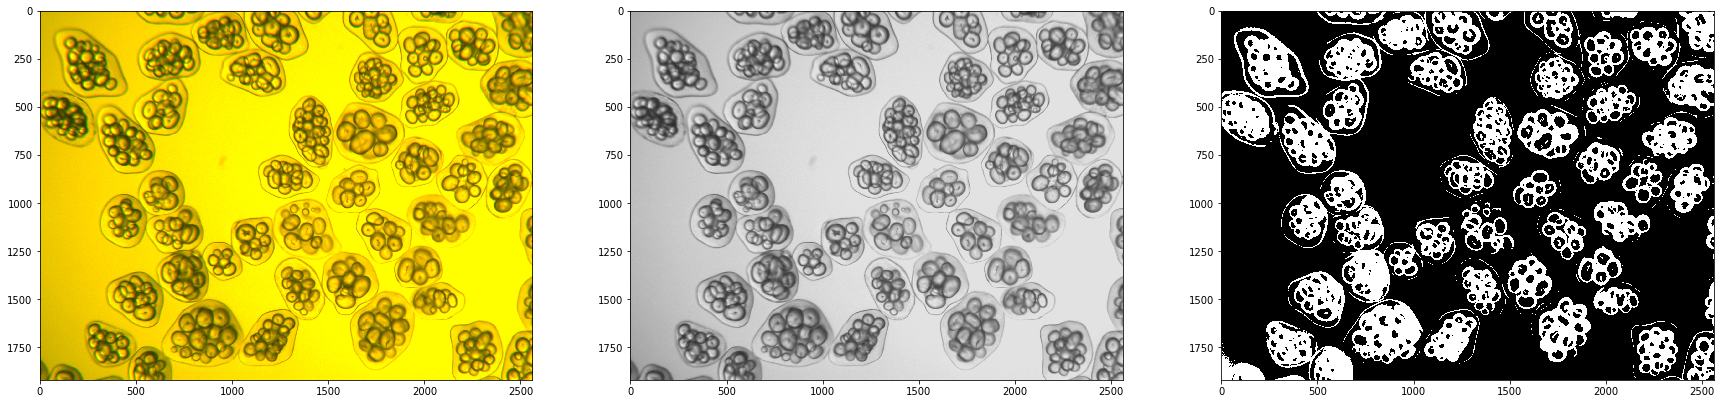

In [2]:
#Get grayscale image w/ threshold 
img_rgb = cv2.imread('hw2/Cell_Image.jpg')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plot_sbs([img_rgb, img_gray, thresh])

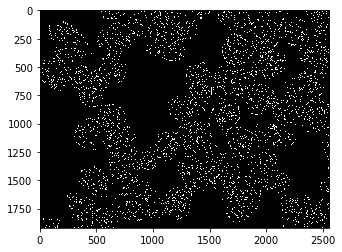

In [3]:
# Get canny edges 
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
v = np.median(blurred)
canny = cv2.Canny(blurred, 25, 40)
plt.imshow(cv2.cvtColor(canny, cv2.COLOR_BGR2RGB))
plt.show()

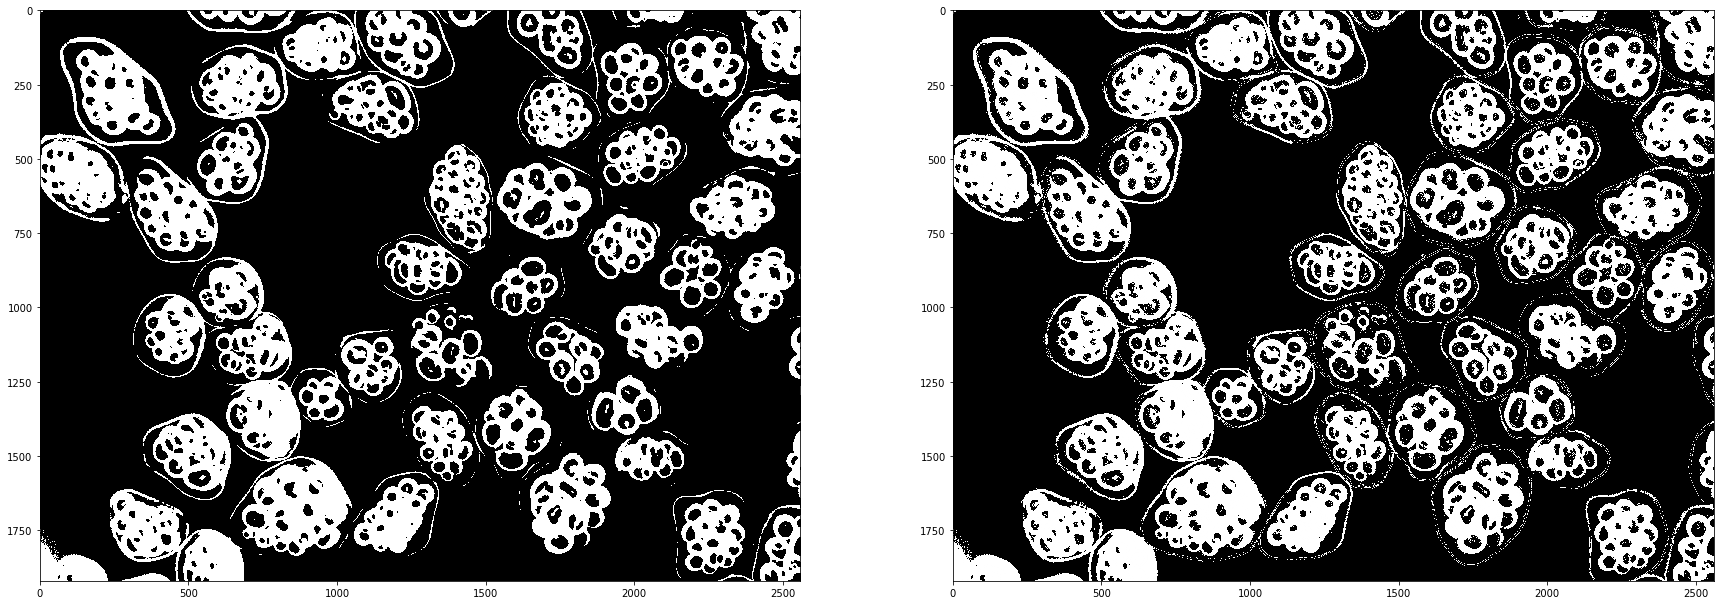

In [4]:
# Enhance edges
before = thresh
thresh = np.clip(thresh + canny, 0, 255)
plot_sbs([before, thresh])

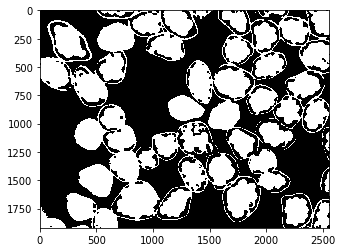

In [5]:
# Fill holes, improves accuracy of distance function
kernel = np.ones((3,3),np.uint8)
opening = ndimage.binary_fill_holes(thresh)
opening = np.array(opening * 255, dtype = np.uint8)
opening = cv2.dilate(opening,kernel,iterations=5)
opening = cv2.erode(opening,kernel,iterations=5)
plt.imshow(cv2.cvtColor(opening, cv2.COLOR_BGR2RGB))
plt.show()

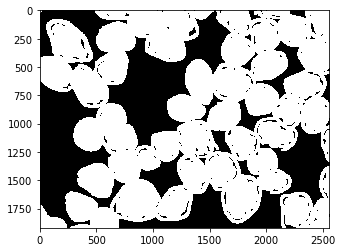

In [6]:
# Dilate to get sure background
kernel = np.ones((5,5),np.uint8)
sure_bg = cv2.dilate(opening,kernel,iterations=5)
plt.imshow(cv2.cvtColor(sure_bg, cv2.COLOR_BGR2RGB))
plt.show()

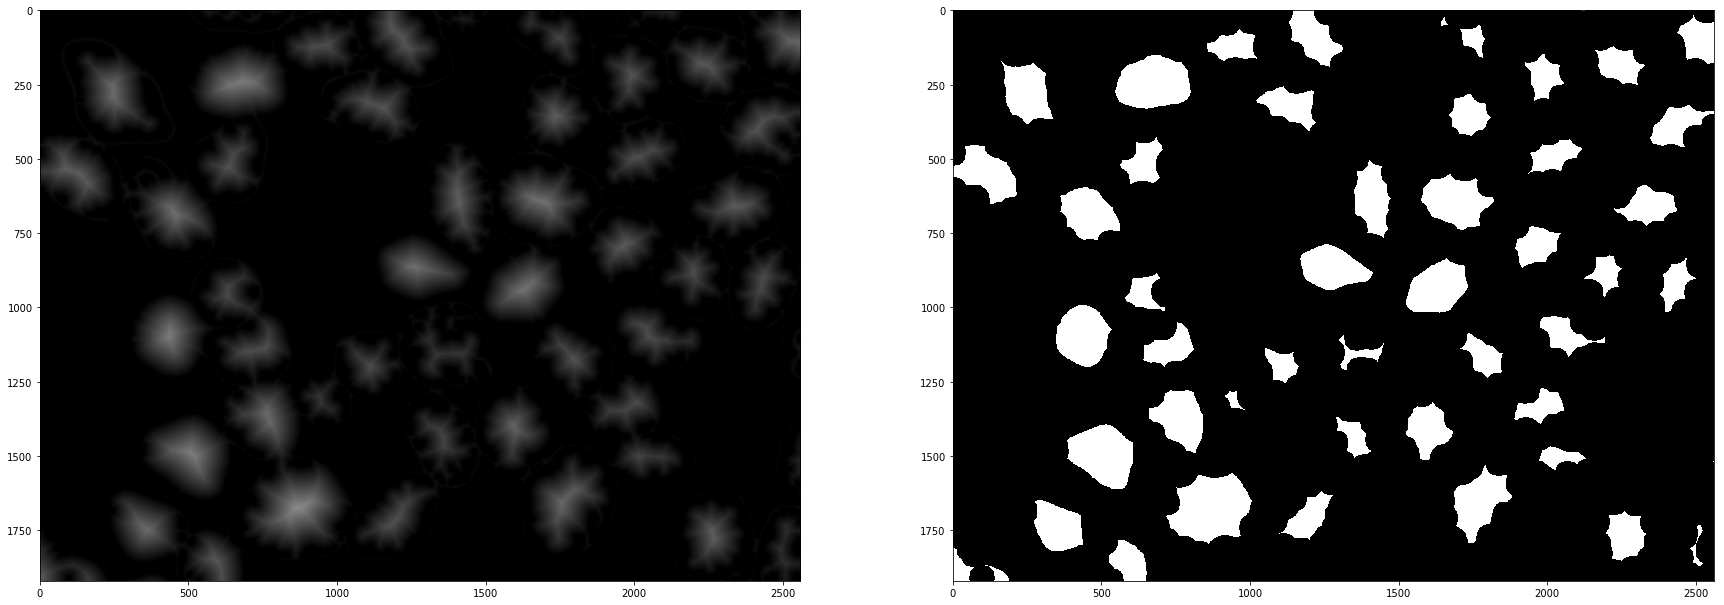

In [7]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.27*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)
plot_sbs([np.uint8(dist_transform), sure_fg])

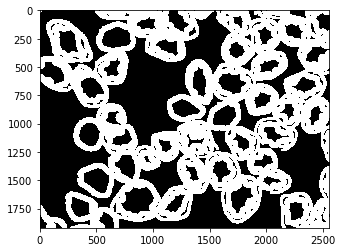

In [8]:
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(cv2.cvtColor(unknown, cv2.COLOR_BGR2RGB))
plt.show()

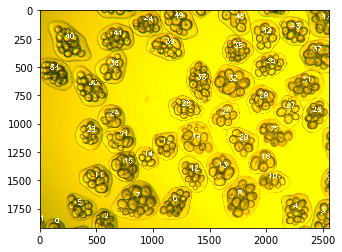

In [9]:
# Add numbering to each cell
contours, hierarchy = cv2.findContours(sure_fg,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)): 
    M = cv2.moments(contours[i])
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.putText(img_rgb, str(i), (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 5)
plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
# Get markers
ret, markers = cv2.connectedComponents(sure_fg)
print('There are ' + str(ret) + ' cells in the image.')

There are 51 cells in the image.


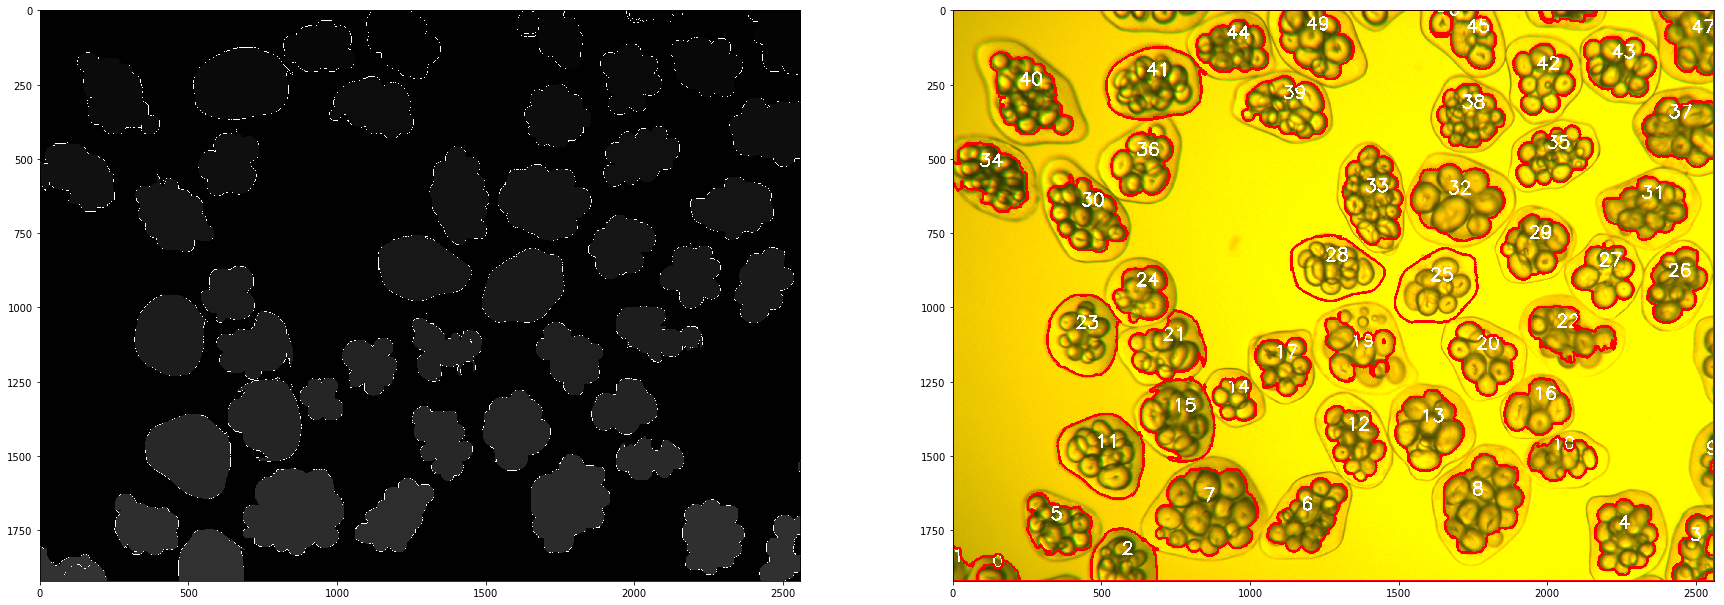

In [11]:
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

kernel = np.ones((3,3),np.uint8)
markers = cv2.watershed(img_rgb,markers)

#draw markers
ret, thresh2 = cv2.threshold(np.uint8(markers),0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh2,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_rgb, contours, -1, (0,0,255), 5)
plot_sbs([np.uint8(markers), img_rgb])